In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate, integrate, optimize
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

import pycbc.conversions as conv

from gwbench import injections
from gwbench import network
from gwbench import snr

# Read simulation

In [2]:
# File with Mc biases

files = ['powerlaw_3.5_lams/powerlaw_alpha_3.5_lam_0_1_Mc_0_1296.csv']

df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_mc = df1.loc[~(df1==0).all(axis=1)]
df_mc = df_mc[df_mc["Mc"] > 0]
print("Total number of events:",len(df_mc))


Total number of events: 1296


In [3]:
# File with eta biases

files = ['powerlaw_3.5_lams/powerlaw_alpha_3.5_lam_0_1_eta_0_1296.csv']

df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_eta = df1.loc[~(df1==0).all(axis=1)]
df_eta = df_eta[df_eta["Mc"] > 0]
print("Total number of events:",len(df_eta))

Total number of events: 1296


$$ p(\alpha) = e^{-N_s} \Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) $$

The products are over all events. 

Or, in log likelihood space, 
$$ log(p(\alpha)) = log(e^{-N_s}) * log(\Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) )$$

which simplifies to 

$$ log(p(\alpha)) = -N_s \Sigma_{i=1}^{N_t} log(N_s * \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1)) $$

#  Define the functions

In [4]:
def p_m1(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])


def normal_dist(m1, mu, sigma):
    A = np.sqrt(2*np.pi) * sigma
    return np.exp(-(m1 - mu) ** 2 / (2 * sigma**2)) / A

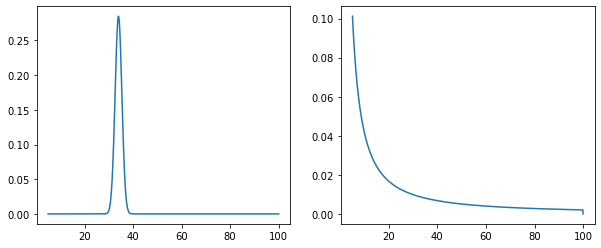

In [6]:
# Visualize the defined functions for sanity

m1_min=5
m1_max=100

m1 = np.linspace(m1_min, m1_max, 1000)
mu = 34
sigma = 1.4
alpha=-1.3

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

ax1.plot(m1, normal_dist(m1, mu, sigma))
ax2.plot(m1, p_m1(m1, alpha, m1_min, m1_max))
plt.show()


# Compute Hyper posterior ($\lambda = 0$)

All the masses here are in the Detector Frame! The original power law sampling was done in SOURCE FRAME.

In [7]:
m1_mu_events = df_mc["m1"] # Add bias here if necessary

mchirp = df_mc["Mc"]
eta = df_mc["eta"]
sigMc = df_mc["Mc_stat_err"]
sigEta = df_eta["eta_stat_err"]

aux0=((3.+((3.*((1.+(-4.*eta))**0.5))+(10.*(((1.+(-4.*eta))**-0.5)*eta))))**2)
aux1=(aux0*((mchirp**2)*(sigEta**2)))+(25.*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*(sigMc**2))))
m1_sigma_events=0.1*(np.sqrt(((eta**-3.2)*aux1)))



In [8]:
m1_min = 5.0
m1_max = 500.0
Ns = np.sum(df_mc["snr"]>8)
Nt = len(df_mc["Mc"])

m1_int_range = np.linspace(m1_min, m1_max, 10000)

n_alpha = 30
alpha_range = np.linspace(-2, -1, n_alpha)
log_p_alpha_lam_0 = np.zeros(n_alpha)

for a in range(n_alpha):
    alpha = alpha_range[a]
    total_int = 0

    for i in range(Nt):
        integrand = p_m1(m1_int_range, alpha, m1_min, m1_max) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
        int_term = np.sum(integrand)

        total_int = total_int + np.log(Ns) + np.log(int_term)
        
    log_p_alpha_lam_0[a] = -Ns * total_int

most likely alpha= -1.3793103448275863


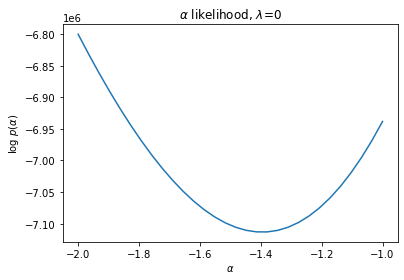

In [9]:
print("most likely alpha=",alpha_range[np.argmin(log_p_alpha_lam_0)])

plt.plot(alpha_range, log_p_alpha_lam_0)
plt.ylabel("log $p(\\alpha$)")
plt.xlabel("$\\alpha$")
plt.title("$\\alpha$ likelihood, $\lambda$=0")
plt.show()


Here are the results if I use source frame masses instead:

In [10]:
m1_mu_events = df_mc["m1"] / (1+df_mc["z"]) # Add bias here if necessary

mchirp = df_mc["Mc"]/ (1+df_mc["z"])
eta = df_mc["eta"]
sigMc = df_mc["Mc_stat_err"]
sigEta = df_eta["eta_stat_err"]

aux0=((3.+((3.*((1.+(-4.*eta))**0.5))+(10.*(((1.+(-4.*eta))**-0.5)*eta))))**2)
aux1=(aux0*((mchirp**2)*(sigEta**2)))+(25.*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*(sigMc**2))))
m1_sigma_events=0.1*(np.sqrt(((eta**-3.2)*aux1)))

m1_min = 5.0
m1_max = 500.0
Ns = np.sum(df_mc["snr"]>8)
Nt = len(df_mc["Mc"])

m1_int_range = np.linspace(m1_min, m1_max, 10000)

n_alpha = 30
alpha_range = np.linspace(-6, -2, n_alpha)
log_p_alpha_lam_0 = np.zeros(n_alpha)

for a in range(n_alpha):
    alpha = alpha_range[a]
    total_int = 0

    for i in range(Nt):
        integrand = p_m1(m1_int_range, alpha, m1_min, m1_max) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
        int_term = np.sum(integrand)

        total_int = total_int + np.log(Ns) + np.log(int_term)
        
    log_p_alpha_lam_0[a] = -Ns * total_int

most likely alpha (IN SOURCE FRAME)= -3.793103448275862


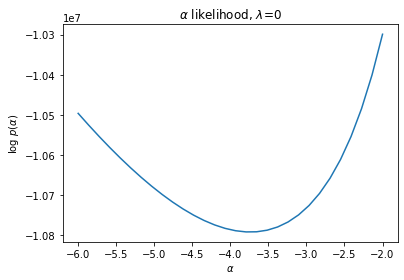

In [11]:
print("most likely alpha (IN SOURCE FRAME)=",alpha_range[np.argmin(log_p_alpha_lam_0)])

plt.plot(alpha_range, log_p_alpha_lam_0)
plt.ylabel("log $p(\\alpha$)")
plt.xlabel("$\\alpha$")
plt.title("$\\alpha$ likelihood, $\lambda$=0")
plt.show()


# Compute Hyper posterior ($\lambda = 1$)

I'm getting some weird results for when the bias makes eta exceed 0.25.

In [12]:
# Add bias here if necessary
mchirp = df_mc["Mc"]+df_mc["bias_19"]
eta = np.minimum(df_eta["eta"]+df_eta["bias_19"], 0.25)

m1_mu_events = conv.mass1_from_mchirp_eta(mchirp, eta)

# Use unbiased mc, eta for sigma_m1 calc, otherwise I get a bunch of infs
mchirp = df_mc["Mc"]
eta = df_mc["eta"]
sigMc = df_mc["Mc_stat_err"]
sigEta = df_eta["eta_stat_err"]

aux0=((3.+((3.*((1.+(-4.*eta))**0.5))+(10.*(((1.+(-4.*eta))**-0.5)*eta))))**2)
aux1=(aux0*((mchirp**2)*(sigEta**2)))+(25.*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*(sigMc**2))))
m1_sigma_events=0.1*(np.sqrt(((eta**-3.2)*aux1)))



In [13]:
m1_min = 5.0
m1_max = 500.0
Ns = np.sum(df_mc["snr"]>8)
Nt = len(df_mc["Mc"])

m1_int_range = np.linspace(m1_min, m1_max, 20000)

n_alpha = 30
alpha_range = np.linspace(-2, -1, n_alpha)
log_p_alpha_lam_1 = np.zeros(n_alpha)

for a in range(n_alpha):
    alpha = alpha_range[a]
    total_int = 0

    for i in range(Nt):
        integrand = p_m1(m1_int_range, alpha, m1_min, m1_max) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
        int_term = np.sum(integrand)

        total_int = total_int + np.log(Ns) + np.log(int_term)
        
    log_p_alpha_lam_1[a] = -Ns * total_int
    

most likely alpha= -1.4482758620689655


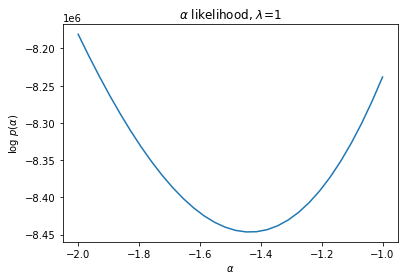

In [14]:
print("most likely alpha=",alpha_range[np.argmin(log_p_alpha_lam_1)])

plt.plot(alpha_range, log_p_alpha_lam_1)
plt.ylabel("log $p(\\alpha$)")
plt.xlabel("$\\alpha$")
plt.title("$\\alpha$ likelihood, $\lambda$=1")
plt.show()